In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler


from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_auc_score
import os

In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [4]:
%matplotlib inline
sns.set_style('darkgrid')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


In [6]:
print(os.getcwd())

/home/avinash/work


In [7]:
root_dir = os.path.join(os.getcwd(), 'dataset/')
print("The data lies here =>", root_dir)

The data lies here => /home/avinash/work/dataset/


In [8]:
from torchvision.transforms import ToTensor, ToPILImage
from styleaug import StyleAugmentor

class StyleAugment(object):
    def __call__(self, im):
        # PyTorch Tensor <-> PIL Image transforms:
        toTensor = ToTensor()
        toPIL = ToPILImage()

        # load image:
        im_torch = toTensor(im).unsqueeze(0) # 1 x 3 x 256 x 256
        im_torch = im_torch.to('cuda:0' if torch.cuda.is_available() else 'cpu')

        # create style augmentor:
        augmentor = StyleAugmentor()

        # randomize style:
        im_restyled = augmentor(im_torch)
        
        #return Image.fromarray(im_restyled)
        return toPIL(im_restyled.squeeze().cpu())
    
    def __repr__(self):
        return self.__class__.__name__ + '()'

In [9]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        StyleAugment(),
        transforms.ToTensor()
#         transforms.Normalize([0.5, 0.5, 0.5],
#                              [0.5, 0.5, 0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        StyleAugment(),
        transforms.ToTensor()
#         transforms.Normalize([0.5, 0.5, 0.5],
#                              [0.5, 0.5, 0.5])
    ])
}

In [10]:
train_dataset = datasets.ImageFolder(root = root_dir + "train", transform = image_transforms["train"])

In [11]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 112
    Root location: /home/avinash/work/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               StyleAugment()
               ToTensor()
           )

In [12]:
train_dataset.class_to_idx

{'covid-19': 0, 'normal': 1}

In [13]:
idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}

In [14]:
idx2class

{0: 'covid-19', 1: 'normal'}

In [15]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict


def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

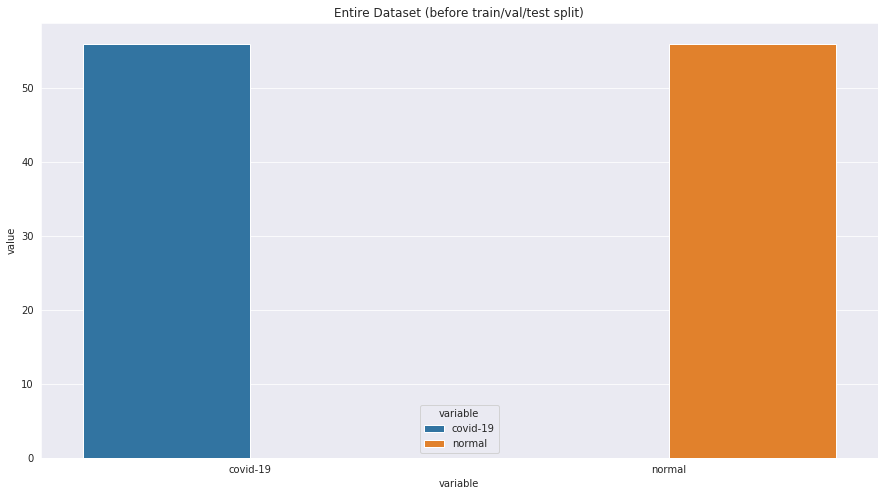

In [16]:
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(train_dataset), plot_title="Entire Dataset (before train/val/test split)")

In [17]:
train_dataset_size = len(train_dataset)

In [18]:
train_dataset_indices = list(range(train_dataset_size))

In [19]:
np.random.shuffle(train_dataset_indices)

In [20]:
val_split_index = int(np.floor(0.2 * train_dataset_size))

In [21]:
train_idx, val_idx = train_dataset_indices[val_split_index:], train_dataset_indices[:val_split_index]

In [22]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [23]:
test_dataset = datasets.ImageFolder(root = root_dir + "test",
                                            transform = image_transforms["test"]
                                           )

In [24]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 64
    Root location: /home/avinash/work/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               StyleAugment()
               ToTensor()
           )

In [25]:
train_loader = DataLoader(dataset=train_dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=train_dataset, batch_size=1, sampler=val_sampler)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [26]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
        
            
    return count_dict

Text(0.5, 1.0, 'val Set')

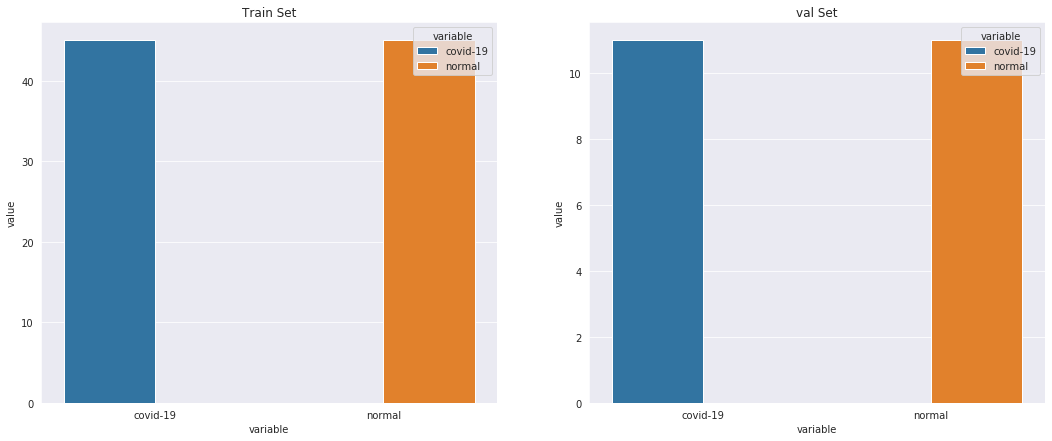

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

plot_from_dict(get_class_distribution_loaders(train_loader,train_dataset), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, train_dataset), plot_title="val Set", ax=axes[1])

In [28]:
 single_batch = next(iter(train_loader))

In [29]:
single_batch[0].shape

torch.Size([8, 3, 224, 224])

In [30]:
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([0, 0, 1, 0, 0, 0, 1, 1])

Output label tensor shape:  torch.Size([8])


In [31]:
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 224, 224])

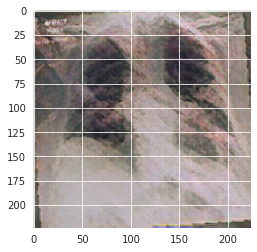

In [32]:
plt.imshow(single_image.permute(1, 2, 0))

In [33]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)

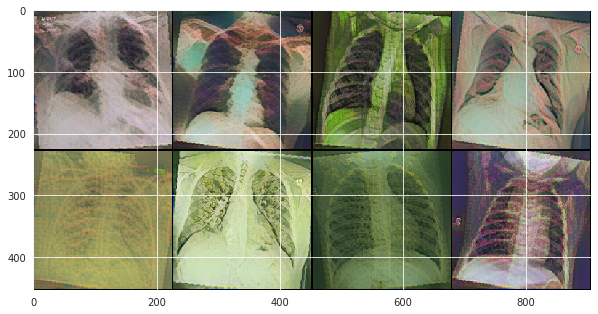

In [34]:
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [35]:
class CovidClassifier(nn.Module):
    def __init__(self):
        super(CovidClassifier, self).__init__()
        
        
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.5, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.5, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.5, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
    
        x = self.block3(x)
        x = self.maxpool(x)
        
        x = self.lastcnn(x)
        
        return x
    
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        return seq_block

In [36]:
model = CovidClassifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)

CovidClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [37]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [38]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [39]:
print("Begin training.")

for e in tqdm(range(1, 16)):
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch).squeeze()
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 01: | Train Loss: 277.44656 | Val Loss: 517.60388 | Train Acc: 42.750| Val Acc: 50.000
Epoch 02: | Train Loss: 108.27463 | Val Loss: 601.39124 | Train Acc: 70.917| Val Acc: 0.000
Epoch 03: | Train Loss: 74.48803 | Val Loss: 0.00000 | Train Acc: 76.167| Val Acc: 100.000
Epoch 04: | Train Loss: 79.54047 | Val Loss: 124.20226 | Train Acc: 73.083| Val Acc: 50.000
Epoch 05: | Train Loss: 69.59967 | Val Loss: 83.90881 | Train Acc: 80.333| Val Acc: 50.000
Epoch 06: | Train Loss: 57.14899 | Val Loss: 0.00000 | Train Acc: 79.333| Val Acc: 100.000
Epoch 07: | Train Loss: 69.27851 | Val Loss: 0.00000 | Train Acc: 85.500| Val Acc: 100.000
Epoch 08: | Train Loss: 40.96315 | Val Loss: 307.67657 | Train Acc: 88.583| Val Acc: 50.000
Epoch 09: | Train Loss: 65.96420 | Val Loss: 0.00000 | Train Acc: 87.667| Val Acc: 100.000
Epoch 10: | Train Loss: 44.93449 | Val Loss: 258.89886 | Train Acc: 89.667| Val Acc: 50.000
Epoch 11: | Train Loss: 16.48361 | Val Loss: 0.00000 | Train Acc: 93.917| Val Acc: 1

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

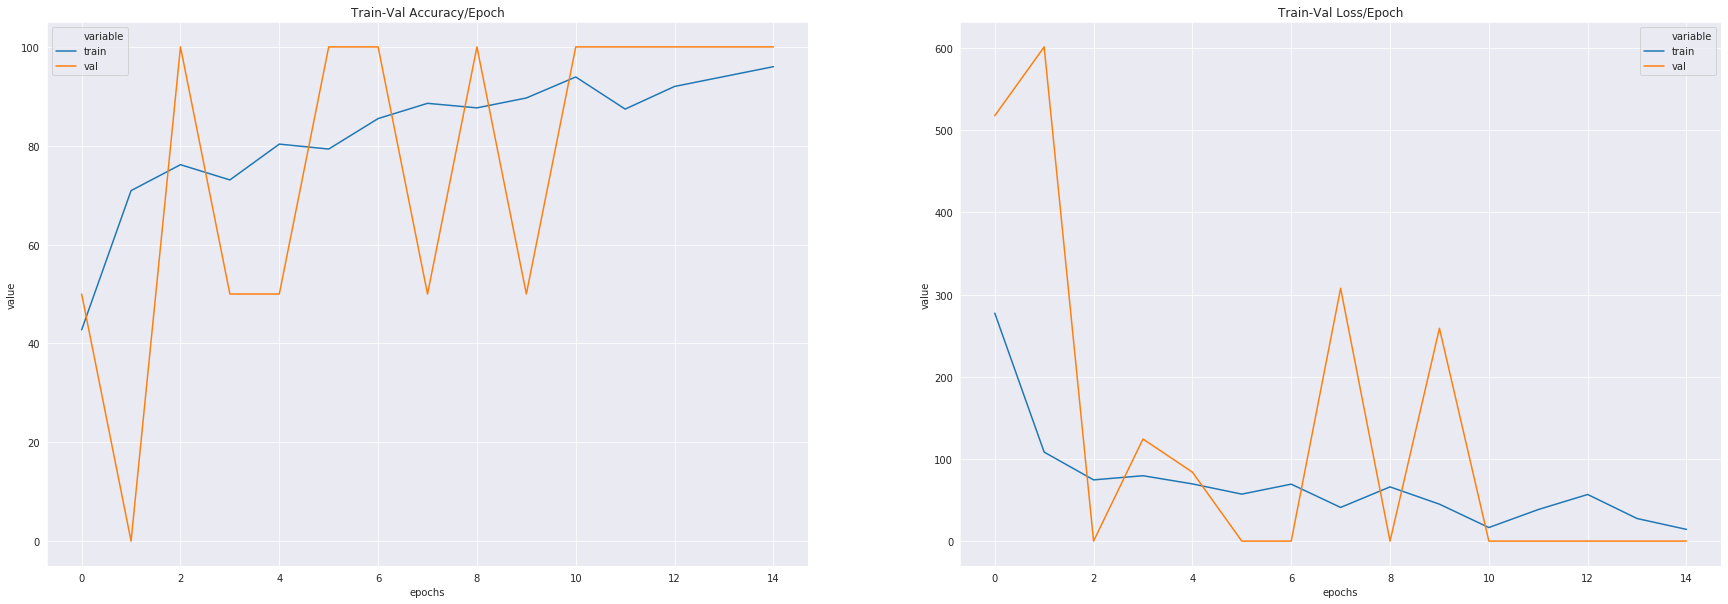

In [40]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [41]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [42]:
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [43]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88        32
           1       0.82      1.00      0.90        32

    accuracy                           0.89        64
   macro avg       0.91      0.89      0.89        64
weighted avg       0.91      0.89      0.89        64



In [44]:
print(confusion_matrix(y_true_list, y_pred_list))

[[25  7]
 [ 0 32]]


In [45]:
print(accuracy_score(y_true_list, y_pred_list))

0.890625


In [46]:
print(roc_auc_score(y_true_list, y_pred_list))

0.890625


In [53]:
from sklearn.metrics import roc_curve,roc_auc_score

In [65]:
sns.set()

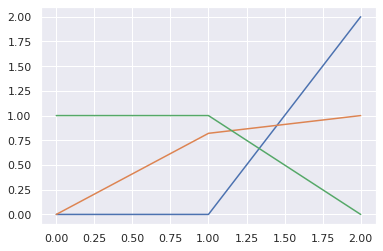

In [66]:
plt.plot(roc_curve(y_pred_list,y_true_list))

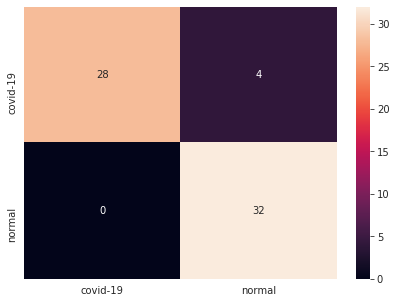

In [70]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)